# Compute Trigger Efficiencies

### In this script, we use the output of a tag-N-probe script to select Z->mu mu events that generate a shower in the CMS Muon Detectors via muon brehmstahlung. We want to compute the efficiency of the HLT triggers that fire upon the production of a shower in the muon endcaps (CSCs). The "tag" muon with tighter ID enables us to select a high purity Z->mu mu sample, while the probe muon, with looser ID constraints, is matched to a cluster in the CSC (we do not require a tight ID on the probe muon to avoid biasing cluster selection). The size of a cluster is the main discriminator, but the HLT threshold varies with eta and NStation10. We compute the trigger efficiency as a function of these three variables.

In [65]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector


### Load Output Trees from TnP

In [66]:
eras = ["all"]

In [67]:
#paths to data
EraE_Path = "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/MuonSystem_TnP__Run2022EraE_probeIso40_tightTag_clusterDecisions.root"
EraF_Path = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TnP_FirstOutput/Run2022EraF.root"
EraG_Path = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TnP_FirstOutput/Run2022EraG.root"
all_path = "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/MuonSystem_TnP_all2022_noJobSplitting_TightTag_LooseIso_TimeVeto.root"

In [68]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [69]:
events_E = getLZDF(EraE_Path)
events_F = getLZDF(EraF_Path)
events_G = getLZDF(EraG_Path)
events_all = getLZDF(all_path)

In [70]:
events_all.fields

['runNum',
 'MC_condition',
 'lumiSec',
 'evtNum',
 'mH',
 'mX',
 'ctau',
 'category',
 'npv',
 'npu',
 'weight',
 'lepOverallSF',
 'pileupWeight',
 'Flag_HBHENoiseFilter',
 'Flag_BadPFMuonFilter',
 'Flag_HBHEIsoNoiseFilter',
 'Flag_CSCTightHaloFilter',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_goodVertices',
 'Flag_ecalBadCalibFilter',
 'Flag_BadChargedCandidateFilter',
 'Flag_eeBadScFilter',
 'Flag_all',
 'Flag2_HBHENoiseFilter',
 'Flag2_HBHEIsoNoiseFilter',
 'Flag2_BadPFMuonFilter',
 'Flag2_globalSuperTightHalo2016Filter',
 'Flag2_globalTightHalo2016Filter',
 'Flag2_BadChargedCandidateFilter',
 'Flag2_EcalDeadCellTriggerPrimitiveFilter',
 'Flag2_ecalBadCalibFilter',
 'Flag2_eeBadScFilter',
 'Flag2_all',
 'rho',
 'met',
 'metPhi',
 'gHiggsPt',
 'gHiggsE',
 'gHiggsEta',
 'gHiggsPhi',
 'nCscRings',
 'nDtRings',
 'nCscRechitClusters',
 'cscRechitCluster_match_gLLP',
 'cscRechitCluster_match_gLLP_minDeltaR',
 'cscRechitCluster_match_gLLP_index',
 'cscRechitCluster_match_gLLP_eta',
 

### First, use one cluster events to verify that our own calculation of the HLT Decision matches what is computed live

In [71]:
oneClusterEvents = {
    "Era_E": events_E[events_E["nCscRechitClusters"]==1],
    "Era_F": events_F[events_F["nCscRechitClusters"]==1],
    "Era_G": events_G[events_G["nCscRechitClusters"]==1],
    "all": events_all[events_all["nCscRechitClusters"]==1]
}

moreClusterEvents= {
    "Era_E": events_E[events_E["nCscRechitClusters"]>1],
    "Era_F": events_F[events_F["nCscRechitClusters"]>1],
    "Era_G": events_G[events_G["nCscRechitClusters"]>1],
    "all": events_all[events_all["nCscRechitClusters"]>1]
}

In [72]:
#validate manual computation of HLT Decision
HLT_validation_Loose = {}
for key,value in oneClusterEvents.items():
    if key!="all":
        continue
    HLT_validation_Loose[key] = {}
    HLT_validation_Loose[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']))
    HLT_validation_Loose[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])))
    HLT_validation_Loose[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']))
    HLT_validation_Loose[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])))
    
HLT_validation_Medium = {}
for key,value in oneClusterEvents.items():
    if key!="all":
        continue
    HLT_validation_Medium[key] = {}
    HLT_validation_Medium[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']))
    HLT_validation_Medium[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])))
    HLT_validation_Medium[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']))
    HLT_validation_Medium[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])))
                                                                        
HLT_validation_Tight = {}
for key,value in oneClusterEvents.items():
    if key!="all":
        continue
    HLT_validation_Tight[key] = {}
    HLT_validation_Tight[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']))
    HLT_validation_Tight[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])))
    HLT_validation_Tight[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']))
    HLT_validation_Tight[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & ~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])))

In [73]:
HLT_validation_Loose

{'all': {'fire_predict_yes': 1392,
  'fire_predict_no': 98,
  'no_fire_predict_yes': 715,
  'no_fire_predict_no': 32991}}

In [74]:
HLT_validation_Medium

{'all': {'fire_predict_yes': 960,
  'fire_predict_no': 99,
  'no_fire_predict_yes': 625,
  'no_fire_predict_no': 33512}}

In [75]:
HLT_validation_Tight

{'all': {'fire_predict_yes': 871,
  'fire_predict_no': 96,
  'no_fire_predict_yes': 596,
  'no_fire_predict_no': 33633}}

### Plot Z-Peak (or other event-by-event hists)

(0.0, 200.0)

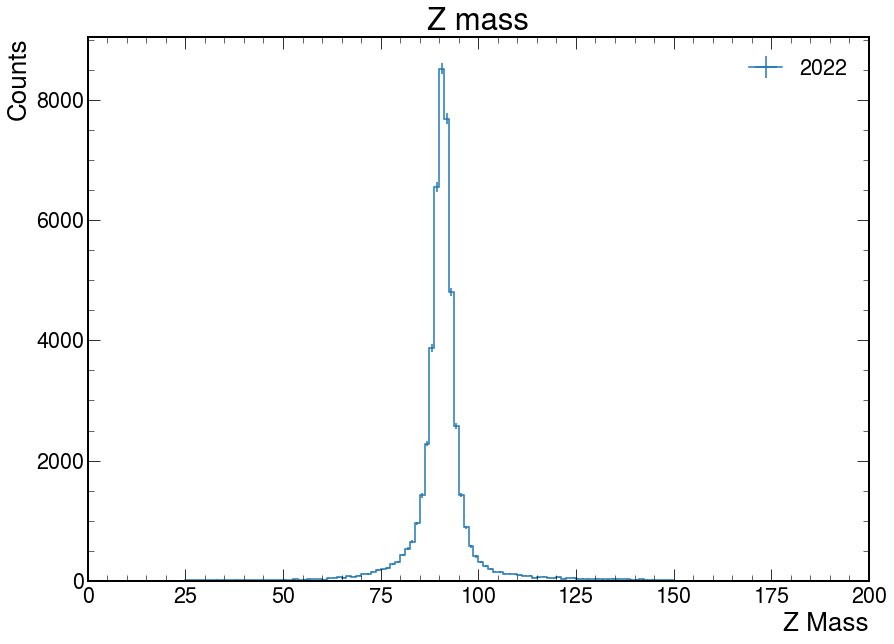

In [76]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_axis = hist.Cat("sample", "2022")
ZMass_hist = hist.Hist("Counts", rechits_axis, hist.Bin("ZMass", "Z Mass", 100, 25, 150))
ZMass_hist.fill(sample = '2022', ZMass = events_all.ZMass)
hist.plot1d(ZMass_hist, density=False)
plt.legend()
plt.title("Z mass")
plt.xlim(0,200)

### Plot Trigger Efficiencies and Other Cluser-by-Cluster Variables

In [77]:
#compute mask for whether a cluster has been matched to a probe muon
matched_clusters_mask = {}
for era in eras:
    one_cluster_mask = np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(oneClusterEvents[era].cscRechitCluster_PassTimeVeto)) 
    many_cluster_mask = np.logical_and(ak.flatten(moreClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(moreClusterEvents[era].cscRechitCluster_PassTimeVeto))       
    matched_clusters_mask[era] = ak.concatenate([one_cluster_mask, many_cluster_mask])

In [78]:
# load HLT Decisions on a cluster-by-cluster basis
# use HLT decision for one cluster events, computed "prediction" for events with more than one cluster
# apply matched cluster mask

HLT_Loose_Decision = {}
for era in eras:
    HLT_Loose_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Loose, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Loose_Decision)]), matched_clusters_mask[era])
    HLT_Loose_Decision[era] = HLT_Loose_Decision[era][~ak.is_none(HLT_Loose_Decision[era])]

HLT_Medium_Decision = {}
for era in eras:
    HLT_Medium_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Medium, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Medium_Decision)]), matched_clusters_mask[era])
    HLT_Medium_Decision[era] = HLT_Medium_Decision[era][~ak.is_none(HLT_Medium_Decision[era])]

HLT_Tight_Decision = {}
for era in eras:
    HLT_Tight_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Tight, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Tight_Decision)]), matched_clusters_mask[era])
    HLT_Tight_Decision[era] = HLT_Tight_Decision[era][~ak.is_none(HLT_Tight_Decision[era])]

In [79]:
#load rechits, eta, and NStation10
matched_clusters_nhits = {}
for era in eras:
    matched_clusters_nhits[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterSize), ak.flatten(moreClusterEvents[era].cscRechitClusterSize)]), matched_clusters_mask[era])
    matched_clusters_nhits[era] = matched_clusters_nhits[era][~ak.is_none(matched_clusters_nhits[era])]
    
matched_clusters_eta = {}
for era in eras:
    matched_clusters_eta[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterEta), ak.flatten(moreClusterEvents[era].cscRechitClusterEta)]), matched_clusters_mask[era])
    matched_clusters_eta[era] = matched_clusters_eta[era][~ak.is_none(matched_clusters_eta[era])]
    
matched_clusters_NStation10 = {}
for era in eras:
    matched_clusters_NStation10[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10), ak.flatten(moreClusterEvents[era].cscRechitClusterNStation10)]), matched_clusters_mask[era])
    matched_clusters_NStation10[era] = matched_clusters_NStation10[era][~ak.is_none(matched_clusters_NStation10[era])]

### Make Efficiency Plots - nRechits

In [80]:
bins_rechits = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.linspace(0, 250, 25), np.linspace(250, 1000, 25)]))
rechits_axis = hist.Cat("sample", "2022 Era")

(0.0, 600.0)

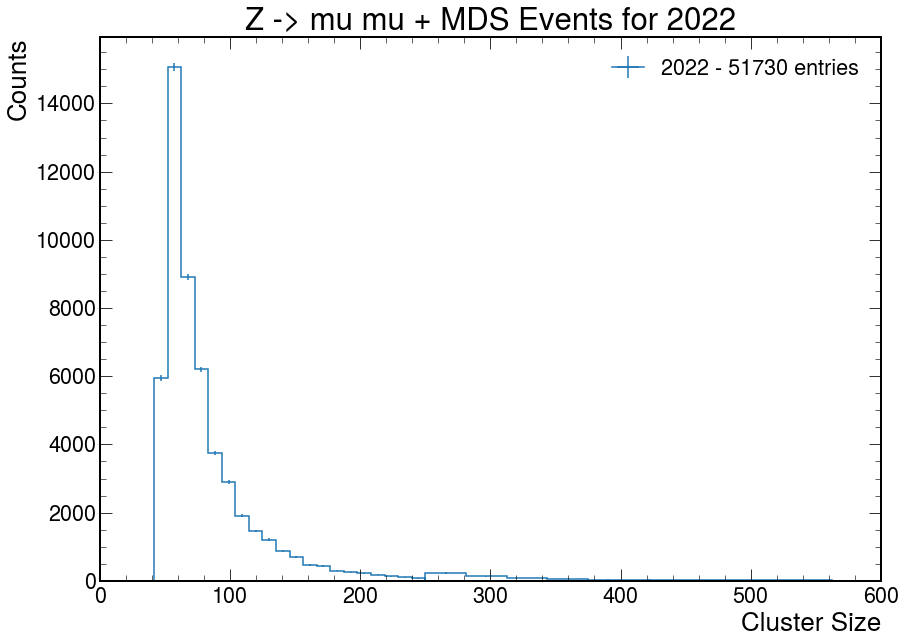

In [81]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_hist = hist.Hist("Counts", rechits_axis, bins_rechits)
arr_to_plot = matched_clusters_nhits["all"]
rechits_hist.fill(sample = f"2022 - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
hist.plot1d(rechits_hist, density=False)
plt.legend()
plt.title("Z -> mu mu + MDS Events for 2022")
plt.xlim(0,600)

Text(0.5, 1.0, 'Z -> mu mu + MDS + Fire HLT Events')

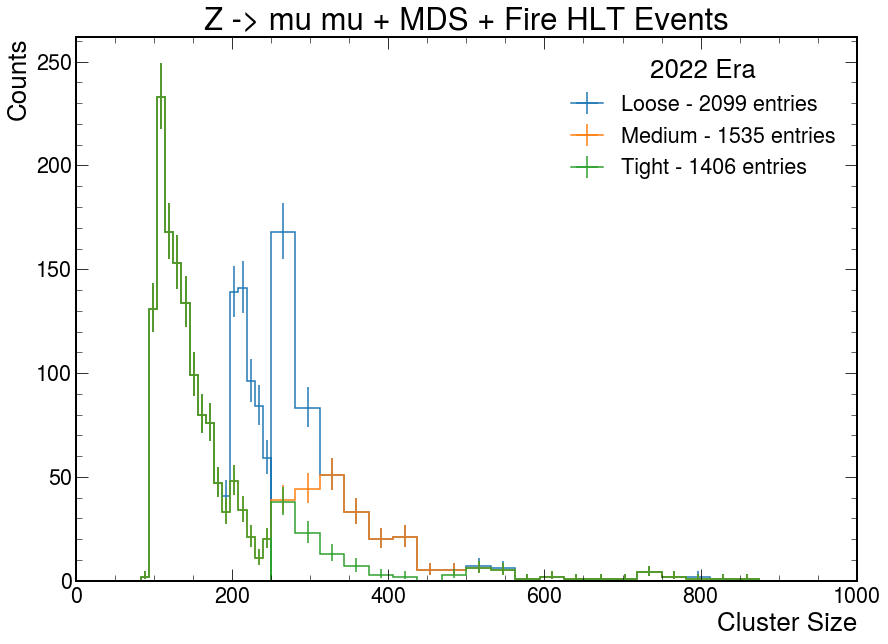

In [82]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))

rechits_hist_HLTLoose = hist.Hist("Counts", rechits_axis, bins_rechits)
arr_to_plot = matched_clusters_nhits["all"][HLT_Loose_Decision["all"]]
rechits_hist_HLTLoose.fill(sample = f"Loose - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
hist.plot1d(rechits_hist_HLTLoose, density=False)


rechits_hist_HLTMedium = hist.Hist("Counts", rechits_axis, bins_rechits)
arr_to_plot = matched_clusters_nhits["all"][HLT_Medium_Decision["all"]]
rechits_hist_HLTMedium.fill(sample = f"Medium - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
hist.plot1d(rechits_hist_HLTMedium, density=False)

rechits_hist_HLTTight = hist.Hist("Counts", rechits_axis, bins_rechits)
arr_to_plot = matched_clusters_nhits["all"][HLT_Tight_Decision["all"]]
rechits_hist_HLTTight.fill(sample = f"Tight - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
hist.plot1d(rechits_hist_HLTTight, density=False)


plt.title("Z -> mu mu + MDS + Fire HLT Events")
#plt.xlim(0,300)
#rechits_hist.plot1d_ratio()

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Efficiency')

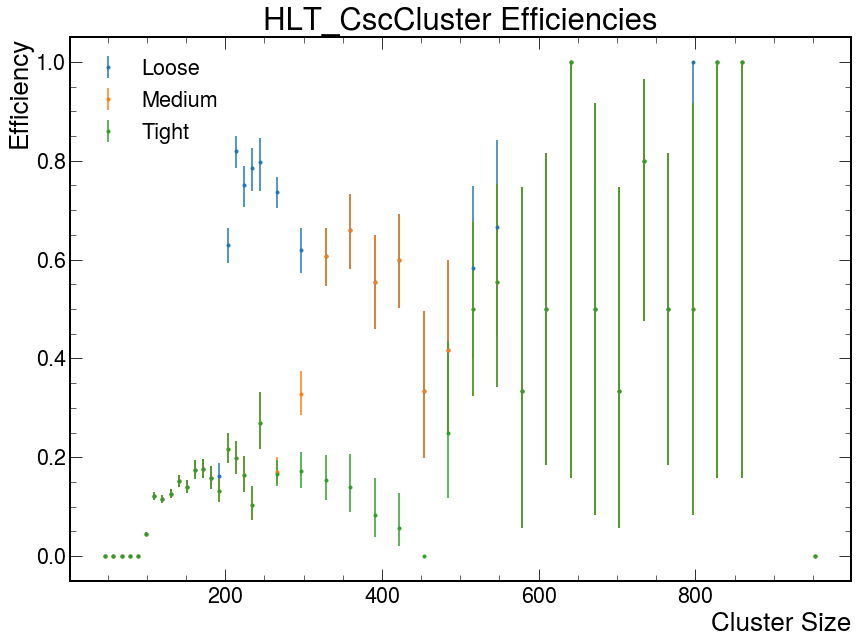

In [83]:
import matplotlib
fig  = plt.figure(figsize=(14,10))
#myAx = matplotlib.axes.Axes(fig, [0.1, 0.1, 0.8, 0.8])
hist.plotratio(
            ax=plt.gca(),
            num  =rechits_hist_HLTLoose.project(bins_rechits),
            denom=rechits_hist.project(bins_rechits),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Loose",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =rechits_hist_HLTMedium.project(bins_rechits),
            denom=rechits_hist.project(bins_rechits),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Medium",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =rechits_hist_HLTTight.project(bins_rechits),
            denom=rechits_hist.project(bins_rechits),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Tight",
            clear=False
        )

plt.legend()
plt.title("HLT_CscCluster Efficiencies")
plt.ylabel("Efficiency")
#plt.xlim(0,300)

### Efficiency Plots - Eta

In [84]:
bins_eta = hist.Bin("eta", "Eta",np.linspace(-4, 4, 100))
eta_axis = hist.Cat("sample", "2022 Era")

(-3.0, 3.0)

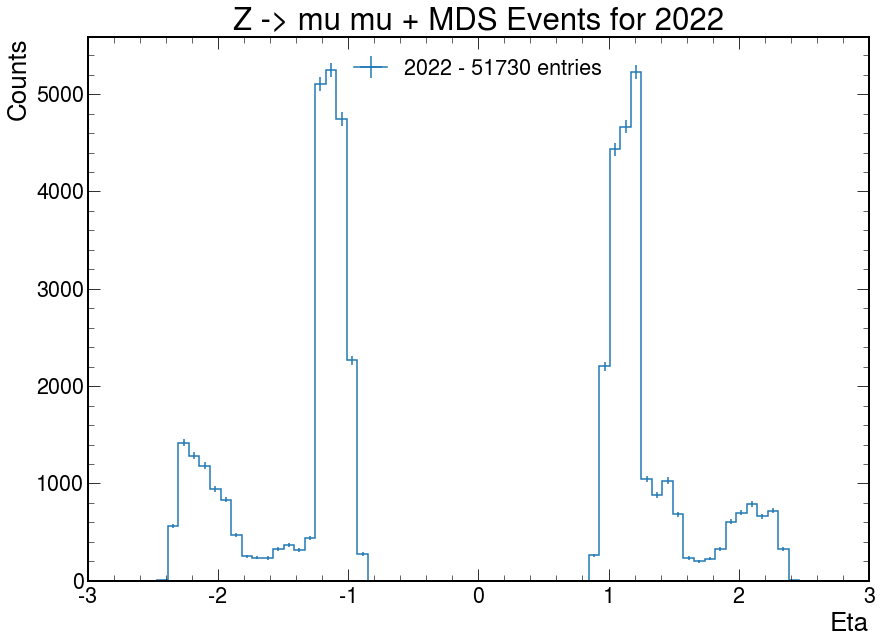

In [85]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
eta_hist = hist.Hist("Counts", eta_axis, bins_eta)
arr_to_plot = matched_clusters_eta["all"]
eta_hist.fill(sample = f"2022 - {ak.count(arr_to_plot)} entries", eta=arr_to_plot)
hist.plot1d(eta_hist, density=False)
plt.legend()
plt.title("Z -> mu mu + MDS Events for 2022")
plt.xlim(-3, 3)

Text(0.5, 1.0, 'Z -> mu mu + MDS + Fire HLT Events')

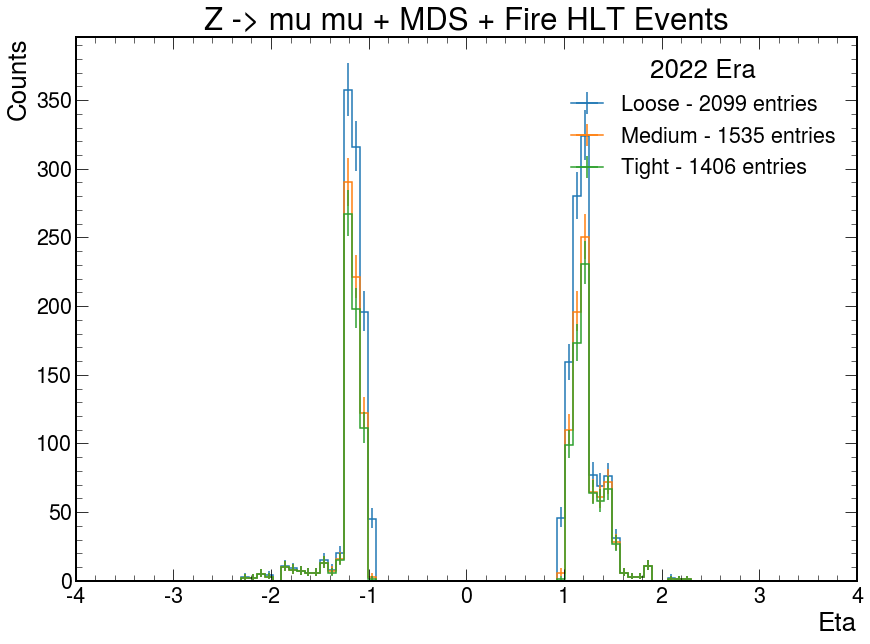

In [86]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))

eta_hist_HLTLoose = hist.Hist("Counts", eta_axis, bins_eta)
arr_to_plot = matched_clusters_eta["all"][HLT_Loose_Decision["all"]]
eta_hist_HLTLoose.fill(sample = f"Loose - {ak.count(arr_to_plot)} entries", eta=arr_to_plot)
hist.plot1d(eta_hist_HLTLoose, density=False)


eta_hist_HLTMedium = hist.Hist("Counts", eta_axis, bins_eta)
arr_to_plot = matched_clusters_eta["all"][HLT_Medium_Decision["all"]]
eta_hist_HLTMedium.fill(sample = f"Medium - {ak.count(arr_to_plot)} entries", eta=arr_to_plot)
hist.plot1d(eta_hist_HLTMedium, density=False)

eta_hist_HLTTight = hist.Hist("Counts", eta_axis, bins_eta)
arr_to_plot = matched_clusters_eta["all"][HLT_Tight_Decision["all"]]
eta_hist_HLTTight.fill(sample = f"Tight - {ak.count(arr_to_plot)} entries", eta=arr_to_plot)
hist.plot1d(eta_hist_HLTTight, density=False)


plt.title("Z -> mu mu + MDS + Fire HLT Events")

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Efficiency')

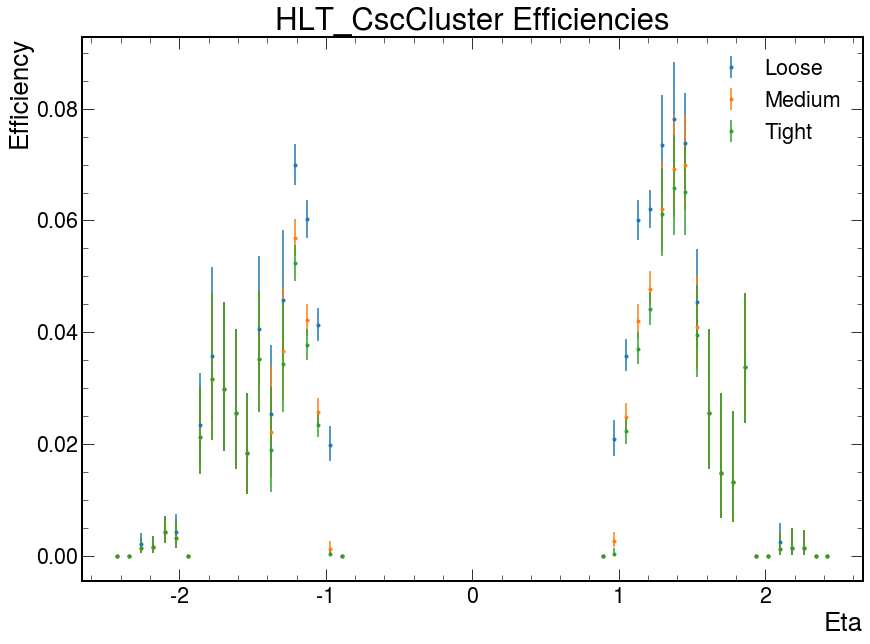

In [87]:
import matplotlib
fig  = plt.figure(figsize=(14,10))
hist.plotratio(
            ax=plt.gca(),
            num =eta_hist_HLTLoose.project(bins_eta),
            denom=eta_hist.project(bins_eta),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Loose",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =eta_hist_HLTMedium.project(bins_eta),
            denom=eta_hist.project(bins_eta),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Medium",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =eta_hist_HLTTight.project(bins_eta),
            denom=eta_hist.project(bins_eta),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Tight",
            clear=False
        )

plt.legend()
plt.title("HLT_CscCluster Efficiencies")
plt.ylabel("Efficiency")
#plt.xlim(0,300)

### Efficiency Plots - NStation10

In [88]:
bins_NStation10 = hist.Bin("NStation10", "NStation10",np.linspace(0, 10, 11))
NStation10_axis = hist.Cat("sample", "2022 Era")

(0.0, 6.0)

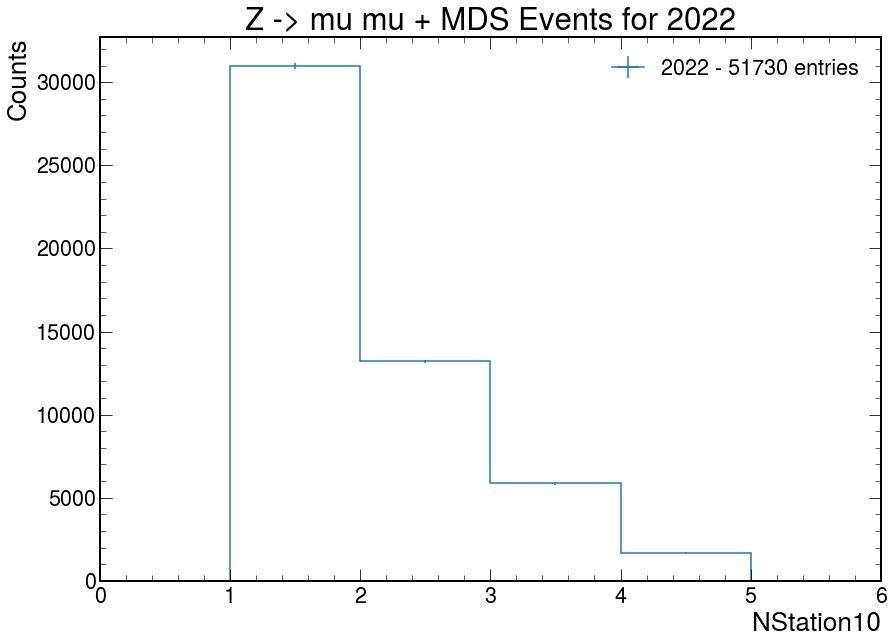

In [89]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
NStation10_hist = hist.Hist("Counts", NStation10_axis, bins_NStation10)
arr_to_plot = matched_clusters_NStation10["all"]
NStation10_hist.fill(sample = f"2022 - {ak.count(arr_to_plot)} entries", NStation10=arr_to_plot)
hist.plot1d(NStation10_hist, density=False)
plt.legend()
plt.title("Z -> mu mu + MDS Events for 2022")
plt.xlim(0, 6)

Text(0.5, 1.0, 'Z -> mu mu + MDS + Fire HLT Events')

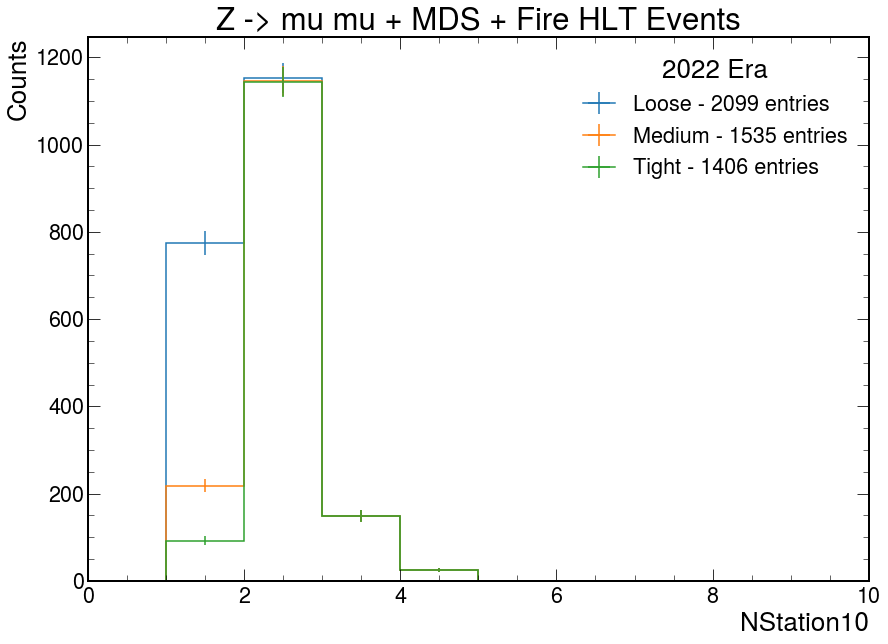

In [90]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))

NStation10_hist_HLTLoose = hist.Hist("Counts", NStation10_axis, bins_NStation10)
arr_to_plot = matched_clusters_NStation10["all"][HLT_Loose_Decision["all"]]
NStation10_hist_HLTLoose.fill(sample = f"Loose - {ak.count(arr_to_plot)} entries", NStation10=arr_to_plot)
hist.plot1d(NStation10_hist_HLTLoose, density=False)


NStation10_hist_HLTMedium = hist.Hist("Counts", NStation10_axis, bins_NStation10)
arr_to_plot = matched_clusters_NStation10["all"][HLT_Medium_Decision["all"]]
NStation10_hist_HLTMedium.fill(sample = f"Medium - {ak.count(arr_to_plot)} entries", NStation10=arr_to_plot)
hist.plot1d(NStation10_hist_HLTMedium, density=False)

NStation10_hist_HLTTight = hist.Hist("Counts", NStation10_axis, bins_NStation10)
arr_to_plot = matched_clusters_NStation10["all"][HLT_Tight_Decision["all"]]
NStation10_hist_HLTTight.fill(sample = f"Tight - {ak.count(arr_to_plot)} entries", NStation10=arr_to_plot)
hist.plot1d(NStation10_hist_HLTTight, density=False)


plt.title("Z -> mu mu + MDS + Fire HLT Events")

In [91]:
#shift bins over by 0.5 so efficiency points are on NStation10 value
newBins_NStation10 = hist.Bin("NStation10", "NStation10",np.linspace(-0.5, 10.5, 12))

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(0.0, 7.0)

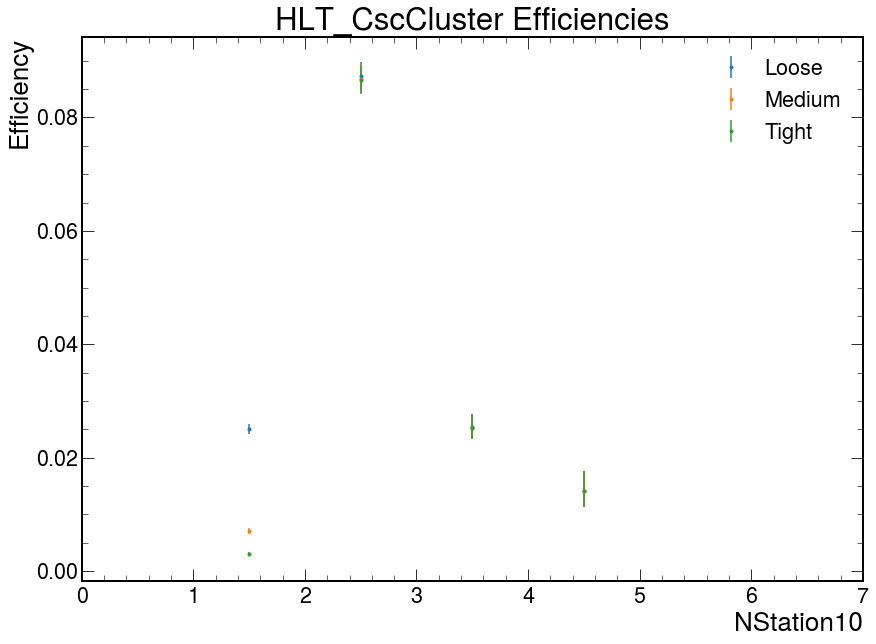

In [92]:
import matplotlib
fig  = plt.figure(figsize=(14,10))
hist.plotratio(
            ax=plt.gca(),
            num =NStation10_hist_HLTLoose.project(bins_NStation10),
            denom=NStation10_hist.project(bins_NStation10),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Loose",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =NStation10_hist_HLTMedium.project(bins_NStation10),
            denom=NStation10_hist.project(bins_NStation10),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Medium",
            clear=False
        )

hist.plotratio(
            ax=plt.gca(),
            num  =NStation10_hist_HLTTight.project(bins_NStation10),
            denom=NStation10_hist.project(bins_NStation10),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label= "Tight",
            clear=False
        )

plt.legend()
plt.title("HLT_CscCluster Efficiencies")
plt.ylabel("Efficiency")
plt.xlim(0,7)